___
## Transfer Learning with Xception 

Hello and welcome to the second notebook in the series exploring image classification for birds. In this notebook we will explore the Xception architecture.

At this stage we assume that the file structure has been loaded into you current working directory following the steps in the first notebook called *BirdClassification.ipynb*. From there the code can be impletemented exactly as it is below. Each section has comments and explaination to guide the reader through. 

Enjoy!
___

In [1]:
# Import libraries

# python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import zipfile
import shutil
import os 

# keras and tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:

# We can wrap ImageDataGenerator up in a function and call it for each architecture we use:
# Each architecture provides its own preprocessing and to get accurate results 
# we must preprocess the input in the same way as to how the model was trained: 


def data_generators(preprocessing): 

    # Xception has the image size requirement of (299,299)
    target_size=(299,299)

    train_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing) # call these two separate imagegen's to allow for adding training augmentation arguements later. 
    
    # Seperate test gen so we don't augment test data. 
    test_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing)


    train_dataset = train_imdatagen.flow_from_directory('birds/train',
                                            target_size= target_size, #all images should be 256x256 so need to resize to 299,299 for xception
                                            class_mode= 'sparse', # changed from 'categorical' gives a label for each class from 0 - number of classes in a vector not one hot like categorical does
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32
    )
    
    validation_dataset = train_imdatagen.flow_from_directory('birds/valid',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )
    
    test_dataset = test_imdatagen.flow_from_directory('birds/test',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )


    return train_dataset, validation_dataset, test_dataset

In [2]:
def plot_history(history, yrange):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy per epoch
    plt.subplot(1,2,1)
    plt.plot(epochs, acc,  label='Train')
    plt.plot(epochs, val_acc , label='Val')
    
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(yrange)
    plt.legend(['Train', 'Val'], loc='lower right')
    
    # Plot training and validation loss per epoch
    #plt.figure()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    
    plt.title('Classification Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    
    #plt.show()
    plt.tight_layout()

Found 35215 images belonging to 250 classes.


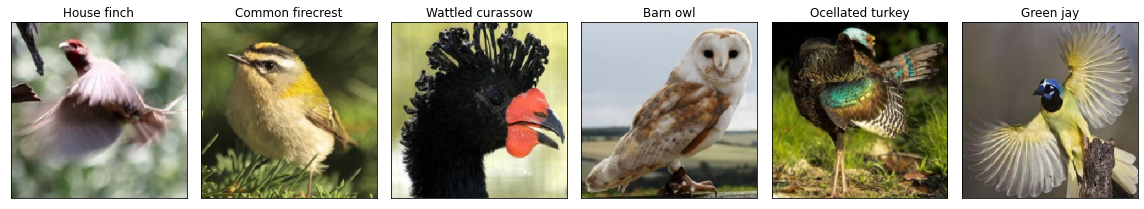

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# create a variable with the unscaled data so we can visualise it
viz_im = ImageDataGenerator()
x_viz = viz_im.flow_from_directory('birds/train', batch_size=16)

bird_dict = x_viz.class_indices
label_list = {v: k.lower().capitalize() for k, v in bird_dict.items()}
label_list


for X, y in x_viz:
    fig, ax = plt.subplots(1, 6, figsize=(16, 16))
    
    for i in range(6):
        img = X[i].astype(np.uint8)
        label = label_list[np.argmax(y[i])]

        ax[i].imshow(img)
        ax[i].set_title(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    
    plt.tight_layout()
    break # We only need the first batch

In [3]:
from keras.preprocessing import image
import random

print('This function will only work if the folder Birds is in your current directory as explained above!')
print('It also requires that a model has already been fitted and stored in the variable *full_model* ')

def model_tester(full_model):
    
    %matplotlib inline

    # This first part selects a random file from the validation directory
    type = random.choice(os.listdir('./Birds/valid'))
    #print(type)
    file = random.choice(os.listdir(f'./Birds/valid/{type}'))
    #print(file)

    random_path = './Birds/valid' + '/' + type + '/' + file
    #print(random_path)

    # We then create the list of labels 
    bird_dict = train_dataset.class_indices
    label_list = {v: k.lower().capitalize() for k, v in bird_dict.items()}
    label_list

    # We then select the image, preprocess and predict the values from full_model
    img_path = random_path
    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    answer=full_model.predict(x)
    probability=round(np.max(full_model.predict(x)*100),2) # We could get the top n here and see if it comes in the top 5 instead of max. 
    
    # Prediction
    print ('This model suggests the image below is a: ',label_list[np.argmax(full_model.predict(x)*100)], ' with a probability of' ,probability,'%' )  # argmax pulls out the first occurence of the max arguement. This is fine for use becuase the softmax should only produce one highest value 
    
    plt.imshow(img) 
   
    # Ground Truth
    print('____________________________________')
    print('The ground truth is:  ' ,type)
    print('____________________________________\n')


    #If we want to display the next two likely outcomes we can use:
    z = full_model.predict(x)*100
    temp = np.argpartition(z[0], -3)[-3:]
    #print(temp)
    #print(z[0][temp])
    temp = np.argsort(-z[0])[:3]

    print('The two next most likely choices are: \n', 
            '          ' , label_list[temp[1]], 'with probability', round(z[0][temp][1], 2),'% \n', 
            '          ' , label_list[temp[2]], 'with probability', round(z[0][temp][2], 2), '%' )
    print('____________________________________')


This function will only work if the folder Birds is in your current directory as explained above!
It also requires that a model has already been fitted and stored in the variable *full_model* 


Using TensorFlow backend.


In [4]:
# Import relavant keras libraries
from keras.applications.xception import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.xception import preprocess_input
from keras.applications.xception import decode_predictions

xception = keras.applications.xception

# When we set include_top = False we tell Keras not to include the 3 fully connected layers at the end of the model. Two dense fully connected layers with Relu 
# and one 1000 neuron softmax layer. We will construct this part ourself and end with a 250 neuron softmax for our problem.  

full_xception = xception.Xception(weights='imagenet', input_shape=(299, 299, 3))

#full_xception.summary()


In [7]:
# Only select first conv part of vgg and remember input shape is 224,224,3   224 x244 image and 3 channels for rgb. 

first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
              input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

first_part_xception.summary()

inputs = first_part_xception.input
outputs = first_part_xception.output

83689472/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           bloc

In [15]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(first_part_xception.output)
# two hidden layers
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dense(1000, activation='relu')(x)
# final softmax layer 250 classes of birds
pred_x = keras.layers.Dense(250, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=first_part_xception.input, outputs=pred_x)
full_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [16]:
# Since the first convolutional part has already been trained on imagenet we can freeze it and only train the last part of the network
# that we created, this will be much faster and then we can customise our layer to increase performance. 

#for layer in first_part_xception.layers:
#    layer.trainable = False

# simply
first_part_xception.trainable = False

# This output shows us that the parameters in the first layers arent trainable. 
full_model = keras.models.Model(inputs=first_part_xception.input, outputs=pred_x)
full_model.summary()


Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [13]:
# Call the data_generator function to create datasets

train_dataset, validation_dataset, test_dataset = data_generators(preprocessing = xception.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


## Run 1 :

Xception with first part frozen, with 2 dense layers each with 1000 neurons each to a softmax layer with 250 outputs (number of classes)

In [18]:
# Compile the model and train. # this was trained with categorical labels in the gen functions and categorical cross entropy as a loss and accuarcy as metric

full_model.compile(loss='sparse_categorical_crossentropy',  optimizer=keras.optimizers.Adam(lr=0.0001),  metrics=['accuracy'])

history = full_model.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=5 )

Epoch 1/5
551/551 [==============================] - 725s 1s/step - loss: 1.2045 - accuracy: 0.7133 - val_loss: 0.4057 - val_accuracy: 0.8776
Epoch 2/5
551/551 [==============================] - 727s 1s/step - loss: 0.2848 - accuracy: 0.9190 - val_loss: 0.3227 - val_accuracy: 0.9112
Epoch 3/5
551/551 [==============================] - 729s 1s/step - loss: 0.1527 - accuracy: 0.9548 - val_loss: 0.3088 - val_accuracy: 0.9216
Epoch 4/5
551/551 [==============================] - 728s 1s/step - loss: 0.1081 - accuracy: 0.9680 - val_loss: 0.2378 - val_accuracy: 0.9296
Epoch 5/5
551/551 [==============================] - 726s 1s/step - loss: 0.1011 - accuracy: 0.9697 - val_loss: 0.3294 - val_accuracy: 0.9128


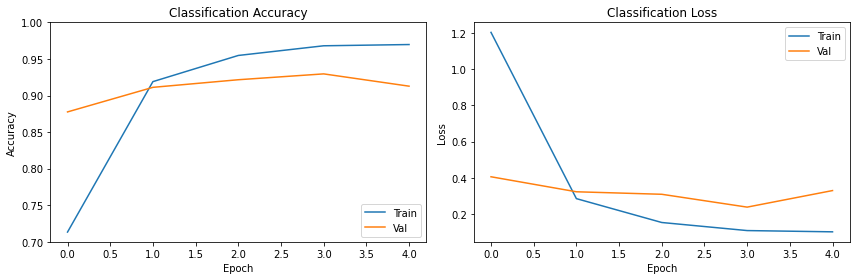

In [20]:
# Plot our results and save val_accuracy to compare in future

xcep_train_acc = history.history['accuracy']
xcep_val_acc = history.history['val_accuracy']

plot_history(history, yrange=(0.7,1))

## Dropout:

We add use gridsearch to test the effects of applying dropout to the hidden dense layers. We also reduced the number of neurons in the dense layer from 1000 in each layer to 250 in each layer to reduce the number of parameters in the model and help with run time. 

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

def create_model(rate):

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = False

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.Dropout(rate)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y=  keras.layers.Dropout(rate)(y)
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.Dropout(rate)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')


Done!


In [28]:

train_dataset, validation_dataset, test_dataset = data_generators(preprocessing = xception.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


To eradicate OOM issues the size of the dense layers were reduced from 2000 and 1000 to simple 250 and 250.

In [31]:
# dropout_percentage = np.arange(0.20, 0.55, 0.05) too long to compute
dropout_percentage = [0.20, 0.30, 0.40]

for rate in dropout_percentage:

    print('Dropout is: ',rate*100, '%')
    model = create_model(rate)
    #model.summary()
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3, verbose=1, workers=10)

Dropout is:  20.0 %
Epoch 1/3
1101/1101 [==============================] - 700s 635ms/step - loss: 3.1658 - accuracy: 0.3335 - val_loss: 0.9172 - val_accuracy: 0.7736
Epoch 2/3
1101/1101 [==============================] - 705s 641ms/step - loss: 1.4039 - accuracy: 0.6413 - val_loss: 0.4653 - val_accuracy: 0.8856
Epoch 3/3
1101/1101 [==============================] - 705s 641ms/step - loss: 0.9436 - accuracy: 0.7442 - val_loss: 0.3903 - val_accuracy: 0.8864
Dropout is:  30.0 %
Epoch 1/3
1101/1101 [==============================] - 706s 641ms/step - loss: 3.9718 - accuracy: 0.2028 - val_loss: 1.8412 - val_accuracy: 0.6024
Epoch 2/3
1101/1101 [==============================] - 705s 641ms/step - loss: 2.2695 - accuracy: 0.4550 - val_loss: 0.9011 - val_accuracy: 0.7960
Epo

We see that having a dropout rate of 30% worked well. If we ran this with more epochs the model wouild continue to learn and the accuracy would increase. It appears as though it has addressed the overfitting issues noticed in the first run. 

## Batch Normalisation

We keep dropout fixed at 30% and introduce a batch normalization layer before the dropout proceedure. 

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

def create_model():

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = False

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')

Done!


In [7]:
# Call the data_generator function to create datasets

train_dataset, validation_dataset, test_dataset = data_generators(preprocessing = xception.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [ ]:
print('Model metrics with Batch Normalisation:')
    
model = create_model()
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3, verbose=1, workers=10)

Model metrics with Batch Normalisation:
Epoch 1/3
1101/1101 [==============================] - 757s 688ms/step - loss: 2.9351 - accuracy: 0.4565 - val_loss: 1.0045 - val_accuracy: 0.8400
Epoch 2/3
1101/1101 [==============================] - 753s 684ms/step - loss: 1.2218 - accuracy: 0.7842 - val_loss: 0.4724 - val_accuracy: 0.9160
Epoch 3/3
 336/1101 [========>.....................] - ETA: 8:20 - loss: 0.7306 - accuracy: 0.8779

### Adding MaxNorm

[Srivastava et.al. (2013)](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) mention in their seminal paper on dropout that a max-norm constraint generally works wells when dropout is applied. We will implement this below and use another gridsearch to test some common values of 1,2,3. We keep the batch normalization and dropout levels the same.  
 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.constraints import max_norm

def create_model(maxnorm):

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = False

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform', kernel_constraint=max_norm(maxnorm))(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform', kernel_constraint=max_norm(maxnorm))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')

Done!


In [16]:
maxnorm = [1., 2., 3.]

for max in maxnorm:

    print('Max norm constraint is: ',max )
    model = create_model(maxnorm)
    #model.summary()
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3, verbose=1, workers=10)

Max norm constraint is:  1.0
Epoch 1/3
1101/1101 [==============================] - 761s 691ms/step - loss: 2.9179 - accuracy: 0.4558 - val_loss: 0.9831 - val_accuracy: 0.8432
Epoch 2/3
1101/1101 [==============================] - 761s 691ms/step - loss: 1.2027 - accuracy: 0.7883 - val_loss: 0.4884 - val_accuracy: 0.9072
Epoch 3/3
1101/1101 [==============================] - 761s 692ms/step - loss: 0.7016 - accuracy: 0.8735 - val_loss: 0.3425 - val_accuracy: 0.9336
Max norm constraint is:  2.0
Epoch 1/3
1101/1101 [==============================] - 764s 694ms/step - loss: 2.9537 - accuracy: 0.4516 - val_loss: 0.9770 - val_accuracy: 0.8536
Epoch 2/3
1101/1101 [==============================] - 761s 691ms/step - loss: 1.2107 - accuracy: 0.7875 - val_loss: 0.5129 - val_accuracy: 0.9152

It doesnt seem to be adding anything extra to the model that batch norm hasn't already addressed. An interesting paper by [Gitman et. al.](https://arxiv.org/pdf/1709.08145.pdf) on the comparison of weight constraints vs. batch normalization actually state that although batch normalisation requires more time during trainign than limiting the weights they noticed for large scale applications in deep networks batch normalization performed significantly better at test time.  

In light of this research we will keep the batch normalisation and discard the max-norm constraint. We can then explore L1 and L2 penalties instead.  

### LASSO,  L1 Regularization

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

def create_model(lambda_value):

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = False

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform',activity_regularizer=tf.keras.regularizers.l1(lambda_value))(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(lambda_value))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')


Done!


In [11]:
# Call the data_generator function to create datasets

train_dataset, validation_dataset, test_dataset = data_generators(preprocessing = xception.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [12]:
lambda_value=[1e-3, 1e-2, 0.1]


for lam in lambda_value:

    print('LASSO Regularisation:   Penalty Hyperparameter=',lam)
    model = create_model(lam)
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=4, verbose=1, workers=10)


LASSO Regularisation:   Penalty Hyperparameter= 0.001
Epoch 1/4
1101/1101 [==============================] - 808s 734ms/step - loss: 3.7437 - accuracy: 0.4687 - val_loss: 1.9159 - val_accuracy: 0.8480
Epoch 2/4
1101/1101 [==============================] - 782s 710ms/step - loss: 2.0917 - accuracy: 0.7681 - val_loss: 1.3276 - val_accuracy: 0.8968
Epoch 3/4
1101/1101 [==============================] - 789s 717ms/step - loss: 1.5479 - accuracy: 0.8329 - val_loss: 1.0758 - val_accuracy: 0.9208
Epoch 4/4
1101/1101 [==============================] - 803s 729ms/step - loss: 1.3068 - accuracy: 0.8570 - val_loss: 0.9762 - val_accuracy: 0.9312
LASSO Regularisation:   Penalty Hyperparameter= 0.01
Epoch 1/4
1101/1101 [==============================] - 785s 713ms/step - loss: 7.3500 - accuracy: 0.2335 - val_loss: 6.1562 - val_accurac

KeyboardInterrupt: 

### Ridge Regression,  L2 Regularization

In [14]:
def create_model(lambda_value):

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = False

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform',activity_regularizer=tf.keras.regularizers.l2(lambda_value))(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l2(lambda_value))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')


Done!


In [15]:
lambda_value=[0.001, 0.0025, 0.005]


for lam in lambda_value:

    print('Ridge Regularisation:   Penalty Hyperparameter=',lam)
    model = create_model(lam)
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=4, verbose=1, workers=10)

Ridge Regularisation:   Penalty Hyperparameter= 0.001
Epoch 1/4
1101/1101 [==============================] - 782s 710ms/step - loss: 5.2067 - accuracy: 0.3195 - val_loss: 4.4108 - val_accuracy: 0.5448
Epoch 2/4
1101/1101 [==============================] - 779s 708ms/step - loss: 4.9956 - accuracy: 0.2503 - val_loss: 4.9620 - val_accuracy: 0.3544
Epoch 3/4
1101/1101 [==============================] - 780s 708ms/step - loss: 5.1449 - accuracy: 0.1903 - val_loss: 5.7324 - val_accuracy: 0.2840
Epoch 4/4
 212/1101 [====>.........................] - ETA: 10:11 - loss: 5.1947 - accuracy: 0.1589

KeyboardInterrupt: 

Here we stopped the run early it seems like the penatly is too harsh with L2 regularisation and the model is unable to learn with the loss diverging. Perhaps it doesnt like all the reularisation steps together. LASSO might work better becuase it actually allows the weights to vanish to zero whilst ridge regression forces the weights to get every closer to zero without actually reaching it. LASSO might be seen as an extra level of dropout, whilst penalising other weights that don't drop out.  This behaviour was also noticed when performing activity regularisation ion the VGG model. 

All hyperparameter tuning was completed with the same training set of data defined by the seed in the flow from directory function, this allowed for an unbiased investigation into the optimal hyperparameters. 


### Putting it all together for a full model run. 

For the hyperparameter choices we will use dropout with a rate of 0.3, batch normalisation and LASSO weight regularisation with a penalty coefficient of 0.001. We will also add image agmentation to further incrase the training set and make a more robust classifier. 

In [3]:
## Set up some directories to save model weights:

#os.mkdir('./BirdsSavedModels/Xception')
#os.mkdir('./BirdsSavedModels/Xception/FullModels')
#os.mkdir('./BirdsSavedModels/Xception/WeightsOnly')

### Add image augmentation to increase robustness of feature selection and increase the training set. 

In [5]:
def data_generators(preprocessing): 

    # Xception has the image size requirement of (299,299)
    target_size=(299,299)

    train_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing,
                                        horizontal_flip=True) # call these two separate imagegen's to allow for adding training augmentation arguements later. 
    
    # Seperate test gen so we don't augment test data. 
    test_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing)


    train_dataset = train_imdatagen.flow_from_directory('birds/train',
                                            target_size= target_size, #all images should be 256x256 so need to resize to 299,299 for xception
                                            class_mode= 'sparse', # changed from 'categorical' gives a label for each class from 0 - number of classes in a vector not one hot like categorical does
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32
    )
    
    validation_dataset = train_imdatagen.flow_from_directory('birds/valid',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )
    
    test_dataset = test_imdatagen.flow_from_directory('birds/test',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )


    return train_dataset, validation_dataset, test_dataset

In [6]:
train_dataset, validation_dataset, test_dataset = data_generators(preprocessing = xception.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [26]:
def create_model():

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = False

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform',activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'] )
    
    return model

print('Done!')

Done!


In [27]:
full_model = create_model()

history = full_model.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=10 )

Epoch 1/10
1101/1101 [==============================] - 782s 710ms/step - loss: 3.7657 - accuracy: 0.4648 - val_loss: 1.9571 - val_accuracy: 0.8656
Epoch 2/10
1101/1101 [==============================] - 793s 720ms/step - loss: 2.1938 - accuracy: 0.7422 - val_loss: 1.3457 - val_accuracy: 0.8936
Epoch 3/10
1101/1101 [==============================] - 784s 712ms/step - loss: 1.6872 - accuracy: 0.7959 - val_loss: 1.1110 - val_accuracy: 0.9056
Epoch 4/10
1101/1101 [==============================] - 782s 710ms/step - loss: 1.4617 - accuracy: 0.8198 - val_loss: 1.0096 - val_accuracy: 0.9192
Epoch 5/10
1101/1101 [==============================] - 789s 717ms/step - loss: 1.3409 - accuracy: 0.8308 - val_loss: 0.9448 - val_accuracy: 0.9200
Epoch 6/10
1101/1101 [======================

In [28]:
full_model.save_weights('./BirdsSavedModels/Xception/WeightsOnly/Run1.h5')
full_model.save('./BirdsSavedModels/Xception/FullModels/Run1.h5')
print('Saved Model!')

Saved Model!


It seems that the LASSO term may be restricting the model from learning. We will train the model for a further 10 epochs with the LASSO penalty restricted and the other forms of regularisation the same. 

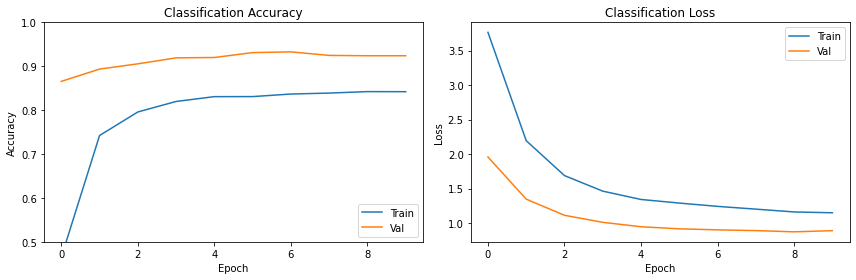

In [30]:
plot_history(history, (0.5,1))

This model suggests the image below is a:  Scarlet ibis  with a probability of 99.45 %
____________________________________
The ground truth is:   SCARLET IBIS
____________________________________

The two next most likely choices are: 
            Glossy ibis with probability 0.53 % 
            Northern bald ibis with probability 0.0 %
____________________________________


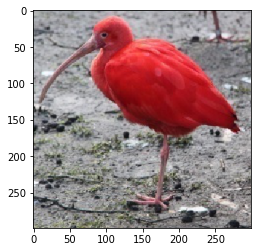

In [34]:
model_tester(full_model)

## We will run the model for another 10 epochs with the lasso penalties removed. 

In [110]:
def create_model():

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = False

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'] )
    
    return model

print('Done!')

Done!


In [111]:
full_model = create_model()
full_model.load_weights('./BirdsSavedModels/Xception/WeightsOnly/Run1.h5')
history = full_model.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=10 )

Epoch 1/10
1101/1101 [==============================] - 781s 709ms/step - loss: 0.6057 - accuracy: 0.8863 - val_loss: 0.3585 - val_accuracy: 0.9432
Epoch 2/10
1101/1101 [==============================] - 782s 710ms/step - loss: 0.5071 - accuracy: 0.9079 - val_loss: 0.3229 - val_accuracy: 0.9512
Epoch 3/10
1101/1101 [==============================] - 786s 714ms/step - loss: 0.4469 - accuracy: 0.9242 - val_loss: 0.3150 - val_accuracy: 0.9480
Epoch 4/10
1101/1101 [==============================] - 804s 730ms/step - loss: 0.4068 - accuracy: 0.9308 - val_loss: 0.3069 - val_accuracy: 0.9456
Epoch 5/10
1101/1101 [==============================] - 803s 730ms/step - loss: 0.3754 - accuracy: 0.9397 - val_loss: 0.2829 - val_accuracy: 0.9600
Epoch 6/10
1101/1101 [============================

In [112]:
full_model.save_weights('./BirdsSavedModels/Xception/WeightsOnly/Run2.h5')
full_model.save('./BirdsSavedModels/Xception/FullModels/Run2.h5')
print('Saved Model!')

Saved Model!


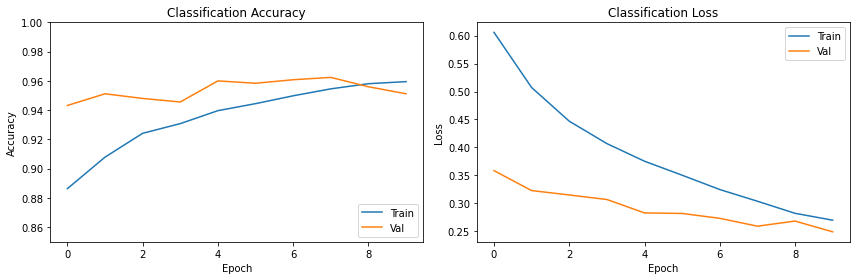

In [113]:
plot_history(history, (0.85,1))

This model suggests the image below is a:  Red headed woodpecker  with a probability of 95.82 %
____________________________________
The ground truth is:   RED HEADED WOODPECKER
____________________________________

The two next most likely choices are: 
            Bearded barbet with probability 1.98 % 
            Barn swallow with probability 0.81 %
____________________________________


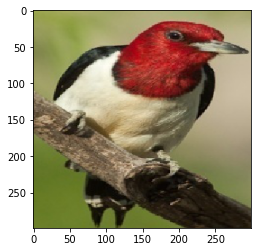

In [114]:
model_tester(full_model)

We have now achieved a better accuracy than the VGG architecture. Using a similar idea we can now unfreeze the Xception layers and retrain the full network for a few epochs and see if it fine tunes the Xception layers to the specific feature associated with the bird classification task. 

## Unfreeze the whole network

We have also reduced the learning rate by a factor of 10 here to make smaller steps in the loss space, our classifier is already good we don't want to take a step in the wrong direction!

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Create a Callback function becuase Azure is being moody and stopping after 2 epochs!


checkpoint_path = "./BirdsSavedModels/Xception/WeightsOnly/Run3.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True,
                             monitor='val_accuracy', 
                             verbose=1, mode='max',
                             save_best_only=True)

checkpoint_list = [checkpoint]

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

def create_model():

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = True

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.00001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')

Done!


In [7]:
full_model = create_model()
full_model.load_weights('./BirdsSavedModels/Xception/WeightsOnly/Run2.h5')
history = full_model.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=10, callbacks=checkpoint_list )

Epoch 1/10
4402/4402 [==============================] - ETA: 0s - loss: 0.9594 - accuracy: 0.7500
Epoch 00001: val_accuracy improved from -inf to 0.95200, saving model to ./BirdsSavedModels/Xception/WeightsOnly/Run3.ckpt
4402/4402 [==============================] - 3103s 705ms/step - loss: 0.9594 - accuracy: 0.7500 - val_loss: 0.1816 - val_accuracy: 0.9520
Epoch 2/10
4402/4402 [==============================] - ETA: 0s - loss: 0.7237 - accuracy: 0.8054
Epoch 00002: val_accuracy improved from 0.95200 to 0.96560, saving model to ./BirdsSavedModels/Xception/WeightsOnly/Run3.ckpt
4402/4402 [==============================] - 3085s 701ms/step - loss: 0.7237 - accuracy: 0.8054 - val_loss: 0.1425 - val_accuracy: 0.9656
Epoch 3/10
 152/4402 [>.............................] - ETA: 48:36 - loss: 0.6948 - accuracy: 0

In [ ]:
full_model.save_weights('./BirdsSavedModels/Xception/WeightsOnly/Run3_h5.h5')
full_model.save('./BirdsSavedModels/Xception/FullModels/Run3_h5.h5')
print('Saved Model!')

## Refreeze the model and train for 5 more epochs

In [7]:
def create_model():

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = False

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'] )
    
    return model

print('Done!')

Done!


In [8]:
full_model = create_model()
full_model.load_weights('./BirdsSavedModels/Xception/WeightsOnly/Run3.ckpt')
history = full_model.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=5 )

Epoch 1/5
1101/1101 [==============================] - 730s 663ms/step - loss: 0.1436 - accuracy: 0.9598 - val_loss: 0.1324 - val_accuracy: 0.9648
Epoch 2/5
1101/1101 [==============================] - 736s 668ms/step - loss: 0.1395 - accuracy: 0.9604 - val_loss: 0.1273 - val_accuracy: 0.9664
Epoch 3/5
1101/1101 [==============================] - 735s 668ms/step - loss: 0.1389 - accuracy: 0.9609 - val_loss: 0.1134 - val_accuracy: 0.9680
Epoch 4/5
1101/1101 [==============================] - 735s 668ms/step - loss: 0.1297 - accuracy: 0.9643 - val_loss: 0.1201 - val_accuracy: 0.9648
Epoch 5/5
1101/1101 [==============================] - 735s 667ms/step - loss: 0.1216 - accuracy: 0.9656 - val_loss: 0.1179 - val_accuracy: 0.9664


In [9]:
full_model.save_weights('./BirdsSavedModels/Xception/WeightsOnly/Run4.h5')
full_model.save('./BirdsSavedModels/Xception/FullModels/Run4.h5')
print('Saved Model!')

Saved Model!


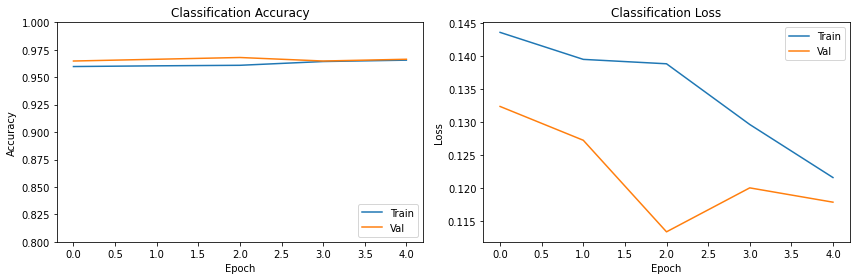

In [10]:
plot_history(history, (0.8,1))

This model suggests the image below is a:  Rufuos motmot  with a probability of 88.21 %
____________________________________
The ground truth is:   RUFUOS MOTMOT
____________________________________

The two next most likely choices are: 
            Turquoise motmot with probability 7.91 % 
            Carmine bee-eater with probability 2.66 %
____________________________________


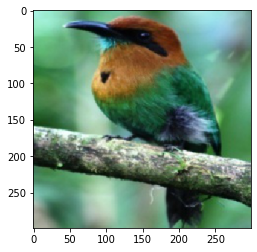

In [11]:
model_tester(full_model)

___
## Model Evaluation on unseen test data

In [14]:
model = create_model()
model.load_weights('./BirdsSavedModels/Xception/WeightsOnly/Run4.h5')

# data_matrix, ground_truth = test_dataset.next()
predictions = full_model.predict(test_dataset, verbose = 1, batch_size=32)

40/40 [==============================] - 72s 2s/step


In [12]:
full_model.evaluate(test_dataset, verbose=1)

40/40 [==============================] - 111s 3s/step - loss: 0.0611 - accuracy: 0.9800


[0.06106721982359886, 0.9800000190734863]

## Achieved a final test accuracy of 98.00% ! Nice. 

In [ ]:
## This unpacks the ground truth data out of batch from the flow from directory function. 
## One time use since the next iterator doesnt reset.  

total_images = test_dataset.n  
steps = total_images//32  ## 32 is batch size
#iterations to cover all data. We add 1 to the step size to account for not integer division i.e. the remaining 2 data points in the last batch

_ , ground_truth = [] , []
for i in range(steps + 1 ):
    _ , b = test_dataset.next() 

    ground_truth.extend(b)


groundT= [int(x) for x in ground_truth]
preds = list(np.argmax(predictions, axis=1))

[[]]

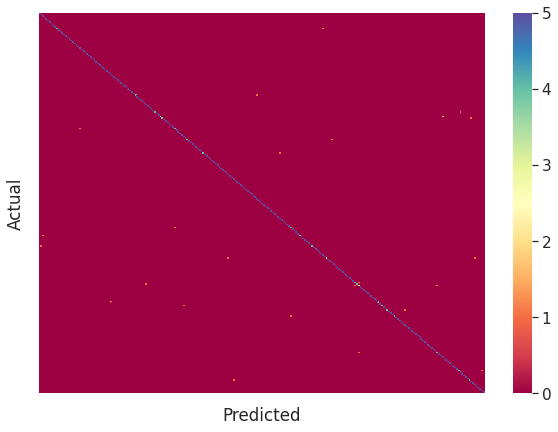

In [18]:
# !pip install seaborn

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

data = confusion_matrix(groundT, preds)

df_cm = pd.DataFrame(data, columns=np.unique(groundT), index = np.unique(preds))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size

g = sns.heatmap(df_cm, cmap="Spectral")
g.set(xticklabels=[])
g.set(yticklabels=[])



In [72]:
df_cm

Predicted,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
Actual,,,,,,,,,,,,,,,,,,,,,
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0
246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,0
247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,0


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report    ....We have confusion matrix above

#print('Confusion Matrix')
#print(confusion_matrix(groundT, preds))

print('Classification Report')
target_names =  list(test_dataset.class_indices.keys())
print(classification_report(groundT, preds))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
     

In [7]:
    bird_dict = train_dataset.class_indices
    label_list = {v: k.lower().capitalize() for k, v in bird_dict.items()}
    label_list

{0: 'African crowned crane',
 1: 'African firefinch',
 2: 'Albatross',
 3: 'Alexandrine parakeet',
 4: 'American avocet',
 5: 'American bittern',
 6: 'American coot',
 7: 'American goldfinch',
 8: 'American kestrel',
 9: 'American pipit',
 10: 'American redstart',
 11: 'Anhinga',
 12: 'Annas hummingbird',
 13: 'Antbird',
 14: 'Araripe manakin',
 15: 'Asian crested ibis',
 16: 'Bald eagle',
 17: 'Bali starling',
 18: 'Baltimore oriole',
 19: 'Bananaquit',
 20: 'Banded broadbill',
 21: 'Bar-tailed godwit',
 22: 'Barn owl',
 23: 'Barn swallow',
 24: 'Barred puffbird',
 25: 'Bay-breasted warbler',
 26: 'Bearded barbet',
 27: 'Belted kingfisher',
 28: 'Bird of paradise',
 29: 'Black francolin',
 30: 'Black skimmer',
 31: 'Black swan',
 32: 'Black throated warbler',
 33: 'Black vulture',
 34: 'Black-capped chickadee',
 35: 'Black-necked grebe',
 36: 'Black-throated sparrow',
 37: 'Blackburniam warbler',
 38: 'Blue grouse',
 39: 'Blue heron',
 40: 'Bobolink',
 41: 'Brown noody',
 42: 'Brown t

In [9]:
import pickle

with open('./BirdsSavedModels/label_list.pickle', 'wb') as handle:
    pickle.dump(label_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
### Save this to a pickle file so we can call it when we load the model. 

___
### Prediction of a random image off the web

In [13]:
## Required imports for this to work:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.xception import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.xception import preprocess_input
from keras.applications.xception import decode_predictions
from keras.models import load_model
from keras.layers import *



# Define the model architecture. Issue with load_model for a functional model so do it this way.

def create_model():

    first_part_xception = xception.Xception(weights='imagenet', include_top=False, 
                input_shape=(299, 299, 3) ) # can add pooling='max' here instead of flattening for the dense layers

    inputs = first_part_xception.input
    outputs = first_part_xception.output
    first_part_xception.trainable = False

    y = keras.layers.Flatten()(outputs)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(250, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'] )
    
    return model

print('Model Architecture Built!')


def any_bird(img_path):

    %matplotlib inline

    #full_model = create_model()
    full_model.load_weights('./BirdsSavedModels/Xception/WeightsOnly/Run2.h5') ## May need to load empty architecture and load weights. Some issue here (or change to a seqential model). 

    # We then create the list of labels ## We might have to save this as a pickle file and load it back in. 
    
    with open('./BirdsSavedModels/label_list.pickle', 'rb') as handle:
        label_list = pickle.load(handle)

    # We then select the image, preprocess and predict the values from full_model

    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) ## Create a batch dimension
    x = preprocess_input(x)
    
    predictions = full_model.predict(x)
    probability=round(np.max(full_model.predict(x)*100),2) # We can expand on this to get the next two top choices like above. 
    
    # Prediction
    print ('This model suggests the image below is a: ',label_list[np.argmax(full_model.predict(x)*100)], ' with a probability of' ,probability,'%' )  # argmax pulls out the first occurence of the max arguement. This is fine for use becuase the softmax should only produce one highest value 
    
    plt.imshow(img) 

This model suggests the image below is a:  Baltimore oriole  with a probability of 46.16 %


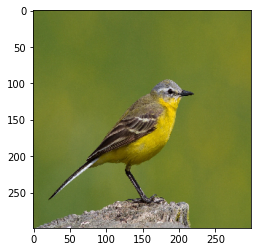

In [157]:
path = './BirdsWebImages/yellowwagtail.jpg'

## This is a Yellow Wagtail 
any_bird(path)

This model suggests the image below is a:  Tasmanian hen  with a probability of 15.87 %


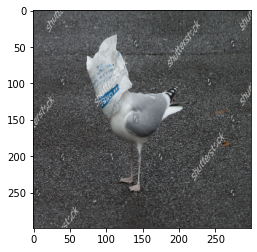

In [160]:
path = './BirdsWebImages/shields_seagull.jpg'
any_bird(path)

This model suggests the image below is a:  Emperor penguin  with a probability of 100.0 %


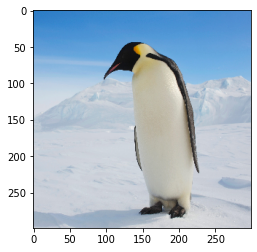

In [163]:
path = './BirdsWebImages/emporer.jpg'
any_bird(path)

This model suggests the image below is a:  Black skimmer  with a probability of 99.99 %


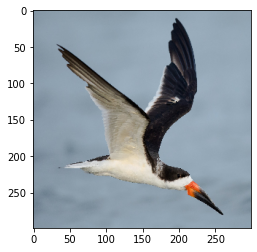

In [14]:
path = './BirdsWebImages/blackskimmer.jpg'
any_bird(path)

Overall the model does very well, as expected of predicting the birds that it has been trained on, even on a completely new image from the web. For other common bird that it has never seen it is not hard to image that it stuggles. Quite obviously a human could tell that a the seagull with it's head in a Gregg's packet is a North Eastern Seagull, and the model predcited a Tasmanian Hen. I know Greggs have done well but I don't think they've made it to Tasmania yet!    

## Thanks for reading.
___